In [1]:
import glob, os, json
import solver
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import time
import math

import traceback

/Users/adam/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [47]:
df = pd.read_pickle("../data/features/analysis.pickle")
# # Drop rows with NA
# rowsBefore = df.shape[0]
# df = df.dropna()
# print("Dropped %d rows due to None values" % (rowsBefore - df.shape[0]))

In [48]:
def loadDeepWalkInstance(path):
    file = open(path, "r")
    
    i = 0
    
    nodeCount = None
    shape = None
    
    instance = None
    
    for line in file:
        if i == 0:
            split = line.split(" ")
            nodeCount = int(split[0])
            length = int(split[1])
            
            instance = np.zeros(shape=(nodeCount, length))
        else:
            split = line.split(" ")
            
            node = split[0]
            encoding = np.array(list(map(float, split[1:])))
            
            instance[i - 1] = encoding
            
        i += 1
    
    file.close()
    
    return instance

def loadDeepWalkInstances(path):
    instances = []
    names = []
    for file in glob.glob(path + "*.deep"):
        try:
            instance = loadDeepWalkInstance(file)
            name = os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]

            instances.append(instance)
            names.append(name)
        except:
            traceback.print_exc()
    
    return instances, names

In [49]:
instances, names = loadDeepWalkInstances("../data/deepwalk/")

In [50]:
len(names)

128

In [51]:
len(df["name"].unique())

168

In [13]:
MAX_SIZE = 1000

In [52]:
# Merge in DeepWalk data
dwInstances = pd.DataFrame(columns=["name", "deepWalk", "sequenceLength"])
reshapedInstances = []
for index, name in enumerate(names):
    instance = instances[index]
    instance = instance.reshape(-1)
    
    size = instance.shape[0]
    
    if size >= MAX_SIZE * MAX_SIZE:
        print("Instance is too large")
    
    zeroed = np.zeros((MAX_SIZE * MAX_SIZE))
    zeroed[0: size] = instance
    
    instance = scale(zeroed.astype('float64')).reshape(MAX_SIZE, MAX_SIZE)
        
#     reshapedInstances.append(scale(zeroed.astype('float64')).reshape(MAX_SIZE, MAX_SIZE))
    
#     reshapedInstances.append(instance)
#     instance = scale(instance.astype('float64'),axis=1)
    dwInstances = dwInstances.append(pd.DataFrame([[name, instance, size]], columns=["name", "deepWalk", "sequenceLength"]))
    
dwInstances = dwInstances.reset_index().drop("index", axis=1)
df = pd.merge(df, dwInstances, on="name")

In [53]:
len(df["name"].unique())

99

In [15]:
minCostIndices = df[["heuristics.tabuCosts", "heuristics.simulatedAnnealingCosts", "heuristics.graspCosts", "heuristics.geneticCosts", "heuristics.antColonyCosts"]].idxmin(axis=1)

In [16]:
inputs = np.array(df["deepWalk"].tolist())
sequenceLengths = np.array(df["sequenceLength"].tolist())

In [19]:
intLabels = LabelEncoder().fit_transform(minCostIndices).reshape(-1, 1)
outputs = OneHotEncoder(sparse=False, n_values=5).fit_transform(intLabels)

In [12]:
values, counts = np.unique(intLabels, return_counts=True)

In [13]:
values

array([0, 1])

In [14]:
outputs

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.]])

In [15]:
scale(df[0].astype('float64'), axis=1)

KeyError: 0

In [16]:
reshapedInstances.astype('float64')

AttributeError: 'list' object has no attribute 'astype'

In [26]:
intLabels = LabelEncoder().fit_transform(minCostIndices).reshape(-1, 1)
# 5 values for 5 different heuristics
outputs = OneHotEncoder(sparse=False, n_values=5).fit_transform(intLabels)

# inputs = df

size = df.shape[0]
# Test data is separated in cleaning stage
trainSize = int(size * 0.75)
validSize = size - trainSize

inputsTrain = inputs[0:trainSize]
lengthsTrain = sequenceLengths[0:trainSize]
outputsTrain = outputs[0:trainSize]
intLabelsTrain = intLabels[0:trainSize]

inputsValid = inputs[trainSize:]
lengthsValid = sequenceLengths[trainSize:]
outputsValid = outputs[trainSize:]
intLabelsValid = intLabels[trainSize:]

In [38]:
values, counts = np.unique(intLabelsTrain, return_counts=True)

In [40]:
counts

array([ 11, 727])

In [43]:
np.unique(minCostIndices, return_counts=True)

(array(['heuristics.antColonyCosts', 'heuristics.graspCosts'], dtype=object),
 array([ 20, 965]))

In [30]:
EPOCHS = 10000

N1 = trainSize
LABEL_COUNT = 5

NODES1 = 512
NODES2 = 256

LSTM_SIZE = 10
LSTM_LAYER_COUNT = 2

ALPHA = 0.08

BATCH_SIZE = 30

STD = 0.1

LEARNING_RATE = 0.1

In [31]:
inputsTrain

array([[[ -6.38828889e+00,   8.61363382e+00,   2.67830730e+01, ...,
           6.79658940e+00,  -3.26268926e+01,   2.15927379e+01],
        [  1.97086095e+01,   2.71050072e+00,  -1.21245916e+01, ...,
          -1.04736238e+01,   3.09240165e+00,  -7.89981256e+00],
        [ -8.85381113e+00,  -9.16787439e+00,  -8.06423092e-02, ...,
          -2.58516687e+01,  -1.31331115e+01,  -1.61750027e+01],
        ..., 
        [ -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03, ...,
          -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03],
        [ -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03, ...,
          -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03],
        [ -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03, ...,
          -9.28713586e-03,  -9.28713586e-03,  -9.28713586e-03]],

       [[ -6.38828889e+00,   8.61363382e+00,   2.67830730e+01, ...,
           6.79658940e+00,  -3.26268926e+01,   2.15927379e+01],
        [  1.97086095e+01,   2.71050072e+00,  -1.21245916e+0

In [32]:
# Define the input function for training
inputFunc = tf.estimator.inputs.numpy_input_fn(
    x={"input": inputsTrain, "length": lengthsTrain}, y=outputsTrain,
    batch_size=BATCH_SIZE, num_epochs=EPOCHS, shuffle=True)

In [33]:
# Define the neural network
def network(xDict):
    x = xDict["input"]
    
    length = xDict["length"]
    
#     input_layer = tf.reshape(x, shape=[-1, MAX_SIZE, MAX_SIZE, 1])
    
    def lstmCell():
        return tf.contrib.rnn.BasicLSTMCell(LSTM_SIZE)
    
    stackedLstm = tf.contrib.rnn.MultiRNNCell([lstmCell() for _ in range(LSTM_LAYER_COUNT)])

#     initialState = stackedLstm.zero_state(batch_size, tf.float32)
    
    output, _ = tf.nn.dynamic_rnn(stackedLstm, x, dtype=tf.float64, sequence_length=length)
    
#     input_layer = tf.cast(input_layer, tf.float32)
    
#     conv1 = tf.layers.conv2d(
#         inputs=input_layer,
#         filters=10,
#         kernel_size=[5, 5],
#         padding="same",
#         activation=tf.nn.relu)
    
#     regularizer = tf.contrib.layers.l2_regularizer(scale=ALPHA)
    
#     conv2 = tf.layers.conv2d(
#         inputs=conv1,
#         filters=20,
#         kernel_size=[3, 3],
#         padding="same",
#         activation=tf.nn.relu)
    
#     # Flatten for fully connected
    flatten = tf.contrib.layers.flatten(output)
    
# #     # Hidden fully connected layer
# #     layer1 = tf.layers.dense(flatten, NODES1, kernel_regularizer=regularizer, activation=tf.nn.relu)
#     # Hidden fully connected layer
#     layer2 = tf.layers.dense(flatten, 64, kernel_regularizer=regularizer, activation=tf.nn.relu)
#     # Output fully connected layer with a neuron for each class
    outLayer = tf.layers.dense(flatten, LABEL_COUNT)
    return outLayer

In [34]:
# Define the model function (following TF Estimator Template)
def modelFunc(features, labels, mode):
    # Build the neural network
    logits = network(features)
    
#     resizedLogits = tf.reshape(logits, shape=[-1, MAX_SIZE * MAX_SIZE, 1])
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)
    
    print(logits.shape)
#     print(resizedLogits.shape)
    print(labels.shape)
    print(pred_classes.shape)
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=tf.argmax(labels, axis=1), predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [35]:
# Build the Estimator
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
model = tf.estimator.Estimator(modelFunc, config=tf.contrib.learn.RunConfig(session_config=config))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a19512d30>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.2
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/2v/nktg94cn4cvfw3vprys2rgtm0000gn/T/tmp8skb6f4x'}


In [36]:
# Train the Model
model.train(inputFunc, steps=100)

(?, 5)
(?, 5)
(?,)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2v/nktg94cn4cvfw3vprys2rgtm0000gn/T/tmp8skb6f4x/model.ckpt.
INFO:tensorflow:loss = 1.60361388261, step = 1
INFO:tensorflow:global_step/sec: 0.374766
INFO:tensorflow:loss = 0.0176100987274, step = 101 (266.971 sec)


KeyboardInterrupt: 

In [37]:
# Evaluate the Model
# Define the input function for evaluating
validFunc = tf.estimator.inputs.numpy_input_fn(
    x={"input": inputsValid, "length": lengthsValid}, y=outputsValid,
    batch_size=BATCH_SIZE, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(validFunc)

(?, 5)
(?, 5)
(?,)
INFO:tensorflow:Starting evaluation at 2018-01-16-20:21:27
INFO:tensorflow:Restoring parameters from /var/folders/2v/nktg94cn4cvfw3vprys2rgtm0000gn/T/tmp8skb6f4x/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-01-16-20:21:38
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.963563, global_step = 1, loss = 1.27857


{'accuracy': 0.96356273, 'global_step': 1, 'loss': 1.2785703}

In [1]:
import functools
import sets
import tensorflow as tf
from tensorflow import nn


def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class VariableSequenceClassification:

    def __init__(self, data, target, num_hidden=200, num_layers=2):
        self.data = data
        self.target = target
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.prediction
        self.error
        self.optimize

    @lazy_property
    def length(self):
        used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @lazy_property
    def prediction(self):
        # Recurrent network.
        output, _ = nn.dynamic_rnn(
            nn.rnn_cell.GRUCell(self._num_hidden),
            data,
            dtype=tf.float32,
            sequence_length=self.length,
        )
        last = self._last_relevant(output, self.length)
        # Softmax layer.
        weight, bias = self._weight_and_bias(
            self._num_hidden, int(self.target.get_shape()[1]))
        prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction

    @lazy_property
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)

    @staticmethod
    def _last_relevant(output, length):
        batch_size = tf.shape(output)[0]
        max_length = int(output.get_shape()[1])
        output_size = int(output.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(output, [-1, output_size])
        relevant = tf.gather(flat, index)
        return relevant


if __name__ == '__main__':
    # We treat images as sequences of pixel rows.
    train, test = sets.Mnist()
    _, rows, row_size = train.data.shape
    num_classes = train.target.shape[1]
    data = tf.placeholder(tf.float32, [None, rows, row_size])
    target = tf.placeholder(tf.float32, [None, num_classes])
    model = VariableSequenceClassification(data, target)
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    for epoch in range(10):
        for _ in range(100):
            batch = train.sample(10)
            print(batch)
            sess.run(model.optimize, {data: batch.data, target: batch.target})
        error = sess.run(model.error, {data: test.data, target: test.target})
        print('Epoch {:2d} error {:3.1f}%'.format(epoch + 1, 100 * error))

/Users/adam/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/adam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use `tf.global_variables_initializer` instead.
data (float64):

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 

data (float64):

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 

KeyboardInterrupt: 

TypeError: Invalid dimensions for image data

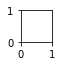

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train, test = sets.Mnist()
batch = train.sample(10)

plt.figure()
for i in range(28):
    loc = int("19"+str(i+1))
    plt.subplot(loc)
    plt.imshow(batch.data[0,i])

In [11]:
batch.data.shape

(10, 28, 28)

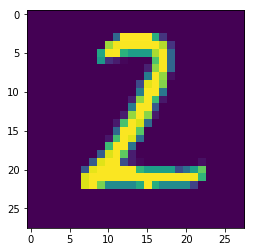

In [16]:
plt.imshow(batch.data[0])